<a href="https://colab.research.google.com/github/LaurentSeguin/Learning_ML/blob/main/Working%20with%20Custom%20Dataset%20In%20Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importing Libraries

In [1]:
import torch
from torch import nn
device ="cuda" if torch.cuda.is_available() else "cpu"

In [2]:
!nvidia-smi

Thu Dec  5 05:13:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1.0 Get the data.

The dataset is a subset of the food101 dataset. It contained only 3 classes of the food and only 10% of the dataset.

When starting out an ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast we can experiment and then scale up.

In [3]:
import requests
import zipfile
from pathlib import Path
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder does not exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exits... skipping download")
else:
  print(f"{image_path} does not exit,creating one....")
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/LaurentSeguin/Learning_ML/raw/main/datasets/pizza_steak_sushi.zip")
  print("Downloading data.....")
  f.write(request.content)

# unzip file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping pizza,steak and sushi data")
  zip_ref.extractall(image_path)




data/pizza_steak_sushi does not exit,creating one....
Unzipping pizza,steak and sushi data


## 2.0 Exploring the data and Preparing the data

In [4]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returing its contents"""
  for  dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'. ")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'. 
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'. 
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'. 
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'. 
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'. 
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'. 
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'. 
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'. 
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'. 


In [6]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir =  image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Steps:
  1. Get all of image paths.
  2. Pick a random image path using Python `random.choice()`
  3. Get the image class name using `pathlib.Path.parent.stem`
  4. Open the image with Python's PIL
  5. Show the image  and print metadata

Random Image path: data/pizza_steak_sushi/test/pizza/3092704.jpg
Image Class: pizza
Image Height: 512
Image Width: 512


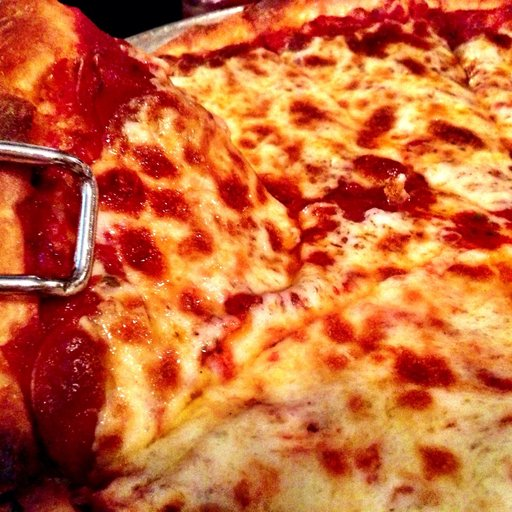

In [7]:
import random
from PIL import Image

# Set random set
#random.seed(42)

# 1. Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # this will look in all the directories and return the path of all files with extension .jpg

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
#print(random_image_path)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image
img= Image.open(random_image_path)

# 5. Print metadata
print(f"Random Image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

#### 2.2 Visualizing with Matplotlib

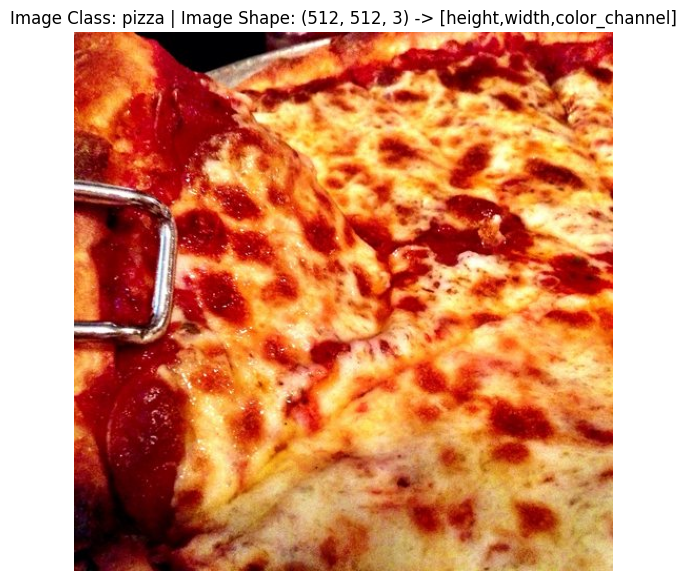

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array  = np.asarray(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape} -> [height,width,color_channel]")
plt.axis(False);

## 3. Transforming Data

Before using the image data with Pytorch, we need:
  1. To turn the data into tensors
  2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we will call this the `Dataset` and the `Dataloader` respectively.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### 3.1 Transforming the data with `torchvision.transforms`

Transform is used to get your images ready to be used with a model/perform data augmentation.

In [10]:
# Write a transform for image.
# With the following code, we will apply different transforms to the images using transform.Compose
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [11]:
#testing the transform function
data_transform(img).shape


torch.Size([3, 64, 64])

In [12]:
def plot_transformed_images(image_paths,transform,n=3,seed=None):
  """
  Selects random images from a path of images and
  load/transform them,
  then plot the original image v/s the transformed one.
  """
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths,k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax=plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Origin Image\nSize:{f.size}")
      ax[0].axis(False)
      # Transform and plot target image
      transform_image = transform(f).permute(1,2,0) # change the shape of the tensor from [c,h,w] to [h,w,c] for matplotlib
      ax[1].imshow(transform_image)
      ax[1].set_title(f"Transformed Image\nSize:{transform_image.shape}")
      ax[1].axis(False)


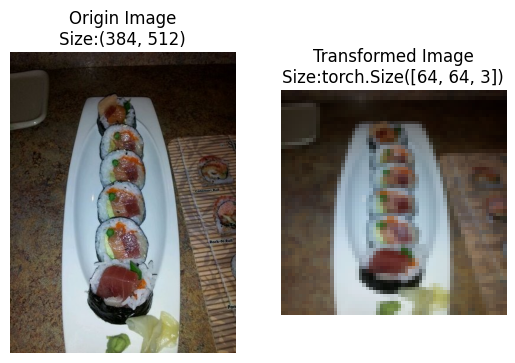

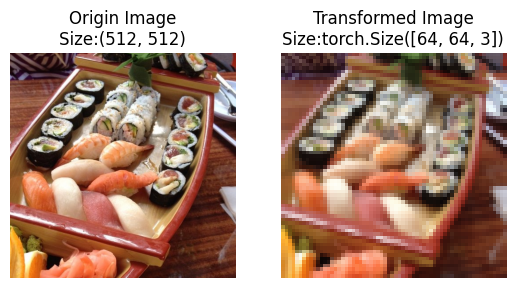

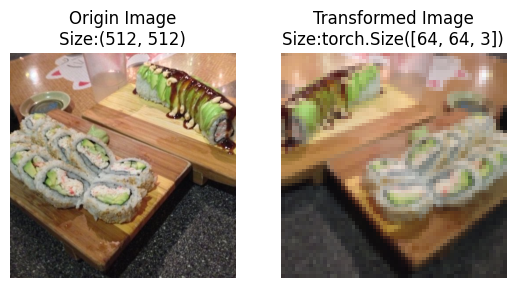

In [13]:
plot_transformed_images(image_path_list,data_transform)

## 4.0 Method 1: Loading images using `ImageFolder`

In [14]:
# Use ImageFolder to create a dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform= data_transform,#transform the data
                                  target_transform=None)# transform the label if required
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the lengths of our dataset
len(train_data),len(test_data)

(225, 75)

In [19]:
# Check one sample
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)